We want to understand whether company XYZ should sell the product at the higher(\$59) or lower price(\$39). The first question, we will try to answer is whether there is a significant effect of the price on conversion. We would also like to understand what factors increase conversion rate. Finally, we will try to understand whether it is possible to step the testing early.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os 
os.chdir('/Users/syedrahman/Documents/Summer2017/Insight/ABtesting')
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns
import datetime as dt
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
import holidays
us_holidays = holidays.UnitedStates() 
import statsmodels.discrete.discrete_model as sm

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
test_data = pd.read_csv('test_results.csv')

In [3]:
user_data = pd.read_csv('user_table.csv')

In [4]:
test_data.shape

(316800, 8)

In [5]:
user_data.shape

(275616, 5)

Had trouble getting the model to run, so I left out user information for the time being.

In [6]:
#data = test_data.merge(user_data, how = 'left', on = 'user_id')
data = test_data

First we check for any null values

In [7]:
data.shape

(316800, 8)

In [8]:
pd.isnull(data).apply(sum, axis = 0)

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [9]:
pd.isnull(test_data).apply(sum, axis = 0)

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

Looks like a lot of the users_id's in the test set is not in the user_data. We will try several different approaches here. The first is to discard the rows where we don't have location information. If location proves to be useful, we can stop there. Or we can impute data based on the other data points. Finally, if location doesn't prove important, we can just focus on the test_data. Let's look at some plots first to see if the data is encoded properly. 

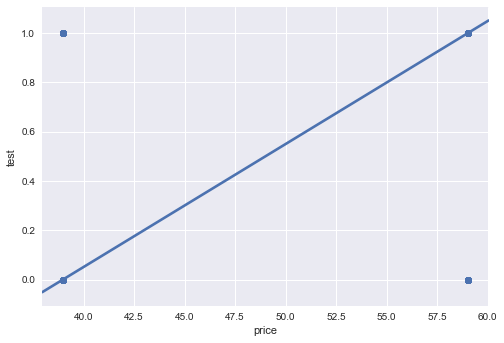

In [10]:
ax = sns.regplot(x="price", y="test", data=data)

Seems like some point in the test have prices of 39, while some points in control have prices of 59. We have to discard these mislabeled points.

In [11]:
cleaned_data = data[(data['test']==1) & (data['price']==59) | (data['test']==0) & (data['price']==39)]

In [12]:
cleaned_data_dropna = cleaned_data.dropna(axis=0)

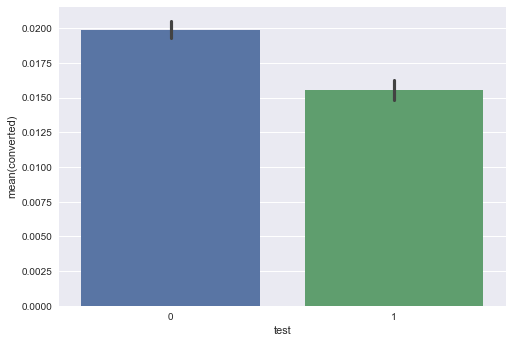

In [13]:
sns.barplot(x = 'test', y= 'converted', data = cleaned_data_dropna)

Seems like the conversion is higher in the control group, so the increased price led to lower conversions. Seems to make sense. But we need to make sure, this was significant. In addition, these are only marginal effects. We will dig further into this later. 

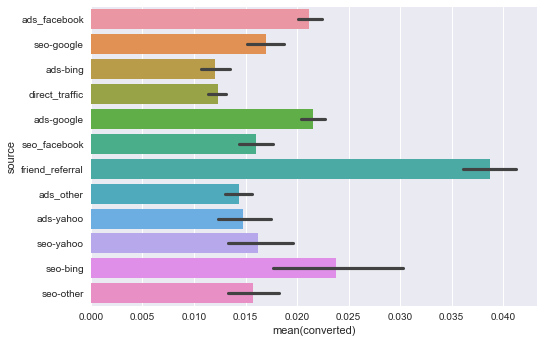

In [14]:
sns.barplot(x = 'converted', y= 'source', data = cleaned_data_dropna)

It's quite clear that friends referrals seems to have the largest effects on converted.

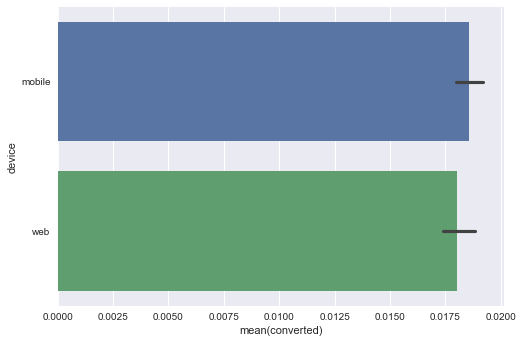

In [15]:
sns.barplot(x = 'converted', y= 'device', data = cleaned_data_dropna)

Not much difference in terms of device, but we should remember that these are marginal effects.

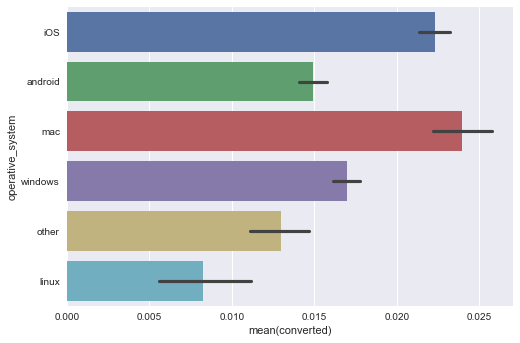

In [16]:
sns.barplot(x = 'converted', y= 'operative_system', data = cleaned_data_dropna)

Also seems like MACs are most likely to convert, while linux's are least likely.

In [17]:
#sns.barplot(x = 'converted', y= 'city', data = cleaned_data_dropna)

There are too many cities to really see which ones make a difference from the plots, but it's clear that marginally it does seem to make a difference. Would be interesting to see what happens when we control for other factors. Now we separate time by hour and days by week.

In [18]:
date_object = []
day_object = []
hour_object = []
holidays_object = []
for x in cleaned_data_dropna['timestamp']:
    try: 
        date_object.append(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
        hour_object.append(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)
        day_object.append(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday())
        holidays_object.append(1.0*(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date() in us_holidays))
    except ValueError:
        date_object.append('NaN')
        hour_object.append('NaN')
        day_object.append('NaN')
        holidays_object.append('Nan')

In [19]:
cleaned_data_dropna['Date'] = pd.to_datetime(pd.Series(date_object)).values
cleaned_data_dropna['Day'] = pd.Series(day_object).values
cleaned_data_dropna['Hour'] = pd.Series(hour_object).values
cleaned_data_dropna['Holidays'] = pd.Series(holidays_object).values

In [20]:
cleaned_data_dropna = cleaned_data_dropna.dropna(axis = 0)

In [21]:
cleaned_data_dropna.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,Date,Day,Hour,Holidays
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08,4,3,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10,6,21,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04,5,15,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07,3,7,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24,6,11,0


In [22]:
X = pd.get_dummies(cleaned_data_dropna['Day'], prefix='Day', prefix_sep='_')

In [23]:
X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['Hour'], prefix='Hour', prefix_sep='_')], axis = 1)

In [24]:
cleaned_data_dropna.columns

Index(['user_id', 'timestamp', 'source', 'device', 'operative_system', 'test',
       'price', 'converted', 'Date', 'Day', 'Hour', 'Holidays'],
      dtype='object')

In [25]:
X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['source'], prefix='source', prefix_sep='_')], axis = 1)

In [26]:
X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['device'], prefix='device', prefix_sep='_')], axis = 1)

In [27]:
X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['operative_system'], prefix='operative_system', prefix_sep='_')], axis = 1)

In [28]:
X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['operative_system'], prefix='operative_system', prefix_sep='_')], axis = 1)

In [29]:
#sum(cleaned_data_dropna['country']!='USA')

Since USA is the only country, country doesn't really matter

I was having trouble getting the model to run, so I left out city information for the time being.

In [30]:
#X = pd.concat([X,pd.get_dummies(cleaned_data_dropna['city'], prefix='city', prefix_sep='_')], axis = 1)

In [31]:
X = pd.concat([X,cleaned_data_dropna['Holidays']], axis = 1)

We will check two types of independent variable. The first is through revenue, which is basically, the price\*conversion while the second is conversion. Since we mostly care about interpretability, we will stick t simple models like the linear regression and logistic regression.  

In [32]:
y_rev = cleaned_data_dropna['price']*cleaned_data_dropna['converted']

In [33]:
y = cleaned_data_dropna['converted']

In [34]:
X_rev = X.loc[cleaned_data_dropna['converted']==1]

In [35]:
y_rev = y_rev.loc[cleaned_data_dropna['converted']==1]

In [36]:
X_rev

,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Hour_0,Hour_1,Hour_2,...,operative_system_mac,operative_system_other,operative_system_windows,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows,Holidays
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
46,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
78,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
107,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
295,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
355,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
403,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
420,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
457,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [37]:
#logreg = LogisticRegressionCV(penalty = 'l1')
#logreg.fit(X,y)
#logreg.coef_ 

In [38]:
#logreg2 = LogisticRegressionCV(penalty = 'l2', class_weight = 'balanced', scoring = 'f1')
#logreg2.fit(X,y)
#print(logreg2.C_)
#print(logreg2.best_estimator_)
#print(logreg2.coef_)

After performing variable selection using the lasso (sklearn automatically cross-validates to pcik the best penalty paramter), we redo the regression using non-zero ceofficients.

In [39]:
#X_red = X[list(X.columns[((logreg2.coef_!=0)[0])])]

To get a balanced dataset we sample randomly from the zeros.

In [40]:
#np.random.seed(1)
#indx = np.random.choice(y[y==0].index,size = sum(y!=0))
#indx2 = y[y!=0].index

In [41]:
#y_red = pd.concat([y.loc[indx],y.loc[indx2]])
#X_red = pd.concat([X.loc[indx],X.loc[indx2]])

In [42]:
#pihat = logreg2.predict_proba(X)[:,0]
#oneMpihat = logreg2.predict_proba(X)[:,1]

In [43]:
#W = np.diag(np.multiply(pihat,oneMpihat))

In [44]:
#logreg3 = LogisticRegression(penalty = 'l2', class_weight = 'balanced')
#logreg3.fit(X_red,y_red)

In [45]:
logreg = LogisticRegression(penalty = 'l2', class_weight = 'balanced', C=1e10)
logreg.fit(X,y)

LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [46]:
y_pred = logreg.predict_proba(X)

In [47]:
pihat = y_pred[:,0]

In [48]:
oneMpihat = y_pred[:,1]

In [ ]:
W = np.diag(pihat*oneMpihat)

In [ ]:
XtW = np.dot(X.transpose(),W)

In [ ]:
XtWX = np.dot(XtW,X)

In [ ]:
var_log = np.linalg.inv(XtWX)

In [ ]:
lower = logreg.coef_ - 1.96*sqrt(np.diag(Var))

In [ ]:
upper = logreg.coef_ + 1.96*sqrt(np.diag(Var))